# Three variable Monte-Carlo real mass function

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import pandas as pd
import scipy as sp

In [180]:
project_path = "/global/cfs/cdirs/des/zhou/spt_selection/"
halo_fname = 'abacus/RShalos_allprops.hdf5'
halo_path = os.path.join(project_path,halo_fname)
f = h5py.File(halo_path,'r')
halos = f['halos']
print(halos.dtype)
mass = halos['m'] 

[('id', '<i8'), ('parent_id', '<i8'), ('pos', '<f4', (3,)), ('vel', '<f4', (3,)), ('corevel', '<f4', (3,)), ('bulkvel', '<f4', (3,)), ('m', '<f4'), ('m_SO', '<f4'), ('r', '<f4'), ('child_r', '<f4'), ('vmax_r', '<f4'), ('mgrav', '<f4'), ('vmax', '<f4'), ('rvmax', '<f4'), ('rs', '<f4'), ('klypin_rs', '<f4'), ('vrms', '<f4'), ('J', '<f4', (3,)), ('energy', '<f4'), ('spin', '<f4'), ('alt_m', '<f4', (4,)), ('alt_m_SO', '<f4', (4,)), ('Xoff', '<f4'), ('Voff', '<f4'), ('b_to_a', '<f4'), ('c_to_a', '<f4'), ('A', '<f4', (3,)), ('b_to_a2', '<f4'), ('c_to_a2', '<f4'), ('A2', '<f4', (3,)), ('bullock_spin', '<f4'), ('kin_to_pot', '<f4'), ('m_pe_b', '<f4'), ('m_pe_d', '<f4'), ('halfmass_radius', '<f4'), ('num_p', '<i8'), ('num_child_particles', '<i8'), ('p_start', '<i8'), ('desc', '<i8'), ('flags', '<i8'), ('n_core', '<i8'), ('subsamp_start', '<i8'), ('subsamp_len', '<i8'), ('min_pos_err', '<f4'), ('min_vel_err', '<f4'), ('min_bulkvel_err', '<f4'), ('N', '<i4'), ('alt_N', '<i4', (4,)), ('N_SO', '<i4

In [181]:
mass = mass[mass > 1E13]

In [514]:
f = os.path.join(project_path,"mass_function.csv")
np.savetxt(f, mass, delimiter=",")

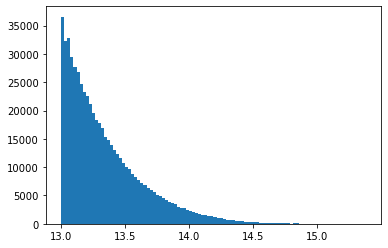

In [182]:
plt.hist(np.log10(mass), bins = 100);

In [183]:
lnM = np.log(mass)
nhalos = len(lnM)

In [184]:
pd.DataFrame(lnM).describe()

,0
count,584257.000000
mean,30.690805
std,0.700417
min,29.936029
25%,30.185188
50%,30.525106
75%,31.067680
max,35.412880


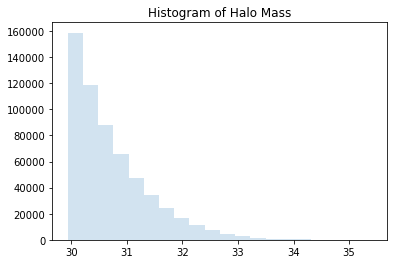

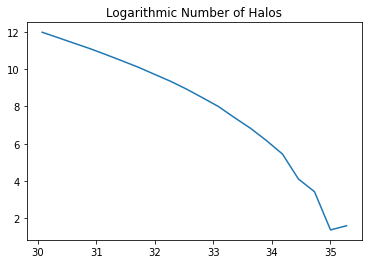

In [185]:
## calculate local slope
hist_data = plt.hist(lnM, alpha=0.2, bins=20)
plt.title("Histogram of Halo Mass")

n = np.log(hist_data[0]) #numbers in each bin
bins = hist_data[1] 
bins = 0.5*(bins[0:-1]+bins[1:])

plt.figure()
plt.plot(bins, n)
plt.title("Logarithmic Number of Halos")

bin_mid = []
slope_mid = []

for i in range(len(bins)-1):
    bin_mid.append(0.5*(bins[i+1] + bins[i]))
    slope = (n[i+1] - n[i])/(bins[i+1] - bins[i])
    slope_mid.append(-slope)
    
# bin_mid.append(np.log(1e16))
# slope_mid.append(0)

from scipy.interpolate import interp1d
mf_slope_interp = interp1d(bin_mid, slope_mid)

In [186]:
print(bin_mid)
print(slope_mid)

[30.20987319946289, 30.483715057373047, 30.757556915283203, 31.03139877319336, 31.305240631103516, 31.579084396362305, 31.852928161621094, 32.12677001953125, 32.400611877441406, 32.67445373535156, 32.94829559326172, 33.22214126586914, 33.4959831237793, 33.76982498168945, 34.04366683959961, 34.317508697509766, 34.59135055541992, 34.865196228027344, 35.1390380859375]
[1.067738997841616, 1.0853059568559724, 1.073033375155709, 1.1692177165070463, 1.211971838065303, 1.232578274308665, 1.371092303349147, 1.359579068472009, 1.5351232164040367, 1.68660810399144, 1.732847168798168, 2.1668857110132294, 2.082115508471662, 2.411328348234273, 2.639288441335948, 4.89393622881451, 2.471815904456222, 7.477543186525994, -0.8148628300185577]


Text(0.5, 0, '')

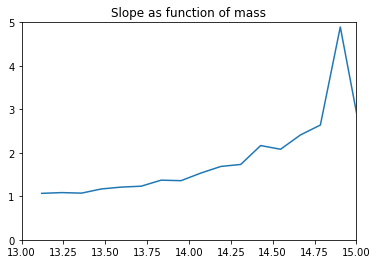

In [187]:
plt.plot(np.log10(np.exp(bin_mid)),slope_mid)
plt.xlim(13,15)
plt.ylim(0,5)
plt.title("Slope as function of mass")
plt.xlabel("")

In [188]:
#using simple scaling relation, change to realistic relation later 

# Richness scaling relations

In [189]:
%run /global/project/projectdirs/des/zhou/spt_selection/header.py

In [190]:
import copy
lnMwl_mean = copy.deepcopy(lnM)
nh = len(lnM)

In [191]:
lnlam_mean = alpha_lam*lnM + pi_lam
lnSZ_mean = alpha_SZ*lnM + pi_SZ

In [192]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

# MonteCarlo

First, Monte Carlo from the covariance matrix and the mean. How does this work? 

Second, define a narrow richness bin to mimic the distribution of halo mass given richness. The expectation value given no correlation should be 
$$\frac{\lambda-\pi_{\lambda}}{\alpha_{\lambda}}$$

But the downward correction is 
$$-(\frac{\sigma_\lambda}{\alpha})^2 \beta$$

Third, 

In [652]:
class MonteCarloObservables(object):
    
    def __init__(self, r, lnM, scatter_Mwl=np.nan, scatter_lam=np.nan, scatter_SZ=np.nan):
    
        self.r = r
        self.scatter_Mwl = scatter_Mwl
        self.scatter_lam = scatter_lam
        self.scatter_SZ = scatter_SZ
        
        mv = multivariate_normal([0, 0], [[1, r], [r, 1]])
        rv = mv.rvs(size=nh)
        x = rv[:,0]
        y = rv[:,1] 
        
        gauss = norm(0,1)
        z = gauss.rvs(size=nh)
 
        self.lnlam = lnlam_mean + scatter_lam * x
        self.lnMwl = lnMwl_mean + scatter_Mwl * y
        self.lnSZ = lnSZ_mean + scatter_SZ * z 
    
    def calculate_diff_mean_halomass_given_lambda(self, lnlam_min = np.log(20), lnlam_max = np.log(21)):        
        
        sel3 = (self.lnlam >= lnlam_min)&(self.lnlam < lnlam_max)
        mean_mass_numerical = np.mean(self.lnMwl[sel3])
    
        # Evrard equation.
        lnM_expected = (self.lnlam[sel3]-lnlam0) / Alam # expectation of no scatter
        mean_mass_theory = np.mean(lnM_expected - beta * (self.scatter_lam / Alam)**2)

        return mean_mass_numerical - mean_mass_theory
    

    def mass_selection_matching_lambda(self, lnM_min=np.log(1e14), lnM_max=np.log(1.1e14)):
        
        sel = (lnM > lnM_min)&(lnM < lnM_max) #Selecting on mass 
        lnM_sel = np.mean(lnM[sel]) #the true halo mass 

        lnlam_sel = self.lnlam[sel] #richness of the halos selected
        
        nbins = 100
        lnlam_bins = np.linspace(min(lnlam_sel)-0.1, max(lnlam_sel)+0.1, nbins+1) 
        #very narrow lambda bins

        lnM_weighted = 0 #initialize empty variable
        mean_mass_theory = 0 # make prediction one bin at a time
        
        for i in range(nbins):
            #define edges of the richness bin
            lnlam_min = lnlam_bins[i]
            lnlam_max = lnlam_bins[i+1]
            
            
            #lambda selection to calculate the weight
            sel2 = (lnlam_sel >= lnlam_min)&(lnlam_sel < lnlam_max)
            weight = len(lnlam_sel[sel2])/len(lnlam_sel)
            
            if weight > 0:
                
                #Calculate the mean mass weighted by 
                sel3 = (self.lnlam >= lnlam_min)&(self.lnlam < lnlam_max)
                lnM_weighted += np.mean(lnM[sel3]) * weight
                
                
                #Calculate the theoretical mean mass 
                lnM_expected = np.mean((self.lnlam[sel3]-lnlam0) / Alam)
                pred = lnM_expected - beta * (self.scatter_lam / Alam)**2 
                mean_mass_theory += pred * weight
                
        return lnM_weighted - mean_mass_theory
    
    def TH_calculate_mean_Mwl_given_lam_SZ(self,lam,SZ,correction=True):
        
        mu_lam = (lam-pi_lam)/alpha_lam
        mu_SZ = (SZ-pi_SZ)/alpha_SZ
        
        sig_lam = scatter_lam/alpha_lam
        sig_SZ = scatter_SZ/alpha_SZ
    
        mu_guess = (mu_lam/(sig_lam)**2 + mu_SZ/(sig_SZ)**2) / (1/sig_lam**2 + 1/sig_SZ**2)
        
        if mu_guess < 30.3:
            beta = 1.06
        elif correction == True:
            beta = mf_slope_interp(mu_guess)
        else: 
            beta= 0
            self.r = 0
        
        
        # print("mu_given_SZ_lam, beta:", mu_guess, beta)
        
        
        mu_given_lam_SZ_num = (alpha_lam/self.scatter_lam**2)*(lam-pi_lam) + (alpha_SZ/self.scatter_SZ**2)*(SZ-pi_SZ) - beta
        mu_given_lam_SZ_den = (alpha_lam/self.scatter_lam)**2 + (alpha_SZ/self.scatter_SZ)**2
        mu_given_lam_SZ = mu_given_lam_SZ_num/mu_given_lam_SZ_den

        mu_given_lam = (lam - pi_lam)/alpha_lam
        mu_given_SZ = (SZ - pi_SZ)/alpha_SZ

        third_term_num = self.r * self.scatter_Mwl * (self.scatter_lam/alpha_lam) * (mu_given_lam - mu_given_SZ + beta*(self.scatter_SZ/alpha_SZ)**2)
        third_term_den = (self.scatter_SZ/alpha_SZ)**2 + (self.scatter_lam/alpha_lam)**2

        third_term = third_term_num/third_term_den

        TH_Mwl_given_lambda_SZ = pi_Mwl + alpha_Mwl*mu_given_lam_SZ + third_term
        # TH_Mwl_given_lambda_SZ = third_term

        return (TH_Mwl_given_lambda_SZ)
    

    def MC_calculate_mean_Mwl_given_lam_SZ(self, nbins, correction):
        
        # lnlam_bins = pd.qcut(self.lnlam[self.lnlam > 3],nbins,retbins=True)[1]
        # lnSZ_bins = pd.qcut(self.lnSZ[self.lnSZ>1.4],nbins,retbins=True)[1]
        
        lnlam_bins = np.log(np.array([20,21,22,24,25,30,40,45,50]))
        lnSZ_bins = np.log(np.array([0.2,0.3,0.4,0.5,1,4,8,10,20]))

                
        diff_array = np.empty([nbins-1])
        SZ_array = np.empty([nbins-1])
        lam_array = np.empty([nbins-1])
        
        diff_array = np.zeros([nbins-1,nbins-1])
        count_array = np.zeros([nbins-1, nbins-1])
        
        for i in range(nbins-1): # go over each SZ bin
            for j in range(nbins-1): #go over each lamdba bin

                SZ_left_edge, SZ_right_edge = lnSZ_bins[i],lnSZ_bins[i+1]
                lam_left_edge, lam_right_edge = lnlam_bins[j],lnlam_bins[j+1]
                
                # print(SZ_left_edge,SZ_right_edge)
                # print(lam_left_edge,lam_right_edge)
                
                SZ_mid = (SZ_left_edge+SZ_right_edge)/2.
                lam_mid = (lam_left_edge+lam_right_edge)/2.
                
                SZ_array[i] = SZ_mid
                lam_array[j] = lam_mid

                SZ_mask = (self.lnSZ > SZ_left_edge) & (self.lnSZ <= SZ_right_edge)
                lam_mask = (self.lnlam > lam_left_edge) & (self.lnlam <= lam_right_edge)
                
                SZ_median = np.median(self.lnSZ[SZ_mask])
                lam_median = np.median(self.lnlam[lam_mask])

                total_mask = SZ_mask & lam_mask  #combine the richness and SZ mask
                count_array[i][j] = np.sum(total_mask)
                

                # print("The halo numbers in SZ mask:",np.sum(SZ_mask))
                # print("The halo numebrs in richness mask:",np.sum(lam_mask))
                # print("The halo numbers in SZ mask and richness mask is:", np.sum(total_mask))

                if np.sum(total_mask) >= 25:

                    # print("The mean lensing mass of given SZ and richness bin is:", np.mean(self.lnMwl[total_mask]))

                    TH_Mwl_given_lambda_SZ = self.TH_calculate_mean_Mwl_given_lam_SZ(lam_median, SZ_median, correction)   

                    diff = (TH_Mwl_given_lambda_SZ - np.mean(self.lnMwl[total_mask]))
                    # diff = TH_Mwl_given_lambda_SZ 
                    #fractional difference
                    diff_array[i][j] = diff

                    # print("The difference between MC and theory is:",diff)

                else:
                    diff_array[i][j] = np.nan

                # print("----------------------------------------------------------")

            
        return(lam_array,SZ_array,diff_array,count_array)
            
            #plot x axis r, bin by SZ and lambda
            #plot x axis lambda, bin by SZ
            #y axis differe

In [653]:
lnlam_bins = pd.qcut(lnlam_mean,5,retbins=True)[1]
print(lnlam_bins)
lnSZ_bins = pd.qcut(lnSZ_mean,5,retbins=True)[1]
print(lnSZ_bins)

[0.56250572 0.74396133 0.97426224 1.28516579 1.77954865 5.70526695]
[-4.612957   -4.31942368 -3.9468689  -3.44392776 -2.64417267  3.70637894]


(array([5.82285e+05, 1.42100e+03, 3.37000e+02, 1.22000e+02, 4.10000e+01,
        1.60000e+01, 1.60000e+01, 7.00000e+00, 3.00000e+00, 2.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 3.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([9.9224346e-03, 2.0447335e+00, 4.0795445e+00, 6.1143556e+00,
        8.1491661e+00, 1.0183977e+01, 1.2218788e+01, 1.4253599e+01,
        1.6288410e+01, 1.8323221e+01, 2.0358032e+01, 2.2392843e+01,
        2.4427654e+01, 2.6462465e+01, 2.8497276e+01, 3.0532087e+01,
        3.2566898e+01, 3.4601711e+01, 3.6636520e+01, 3.8671333e+01,
        4.0706142e+01], dtype=float32),
 <BarContainer object of 20 artists>)

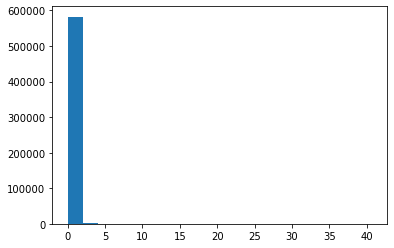

In [654]:
plt.hist(np.exp(lnSZ_mean), bins = 20)

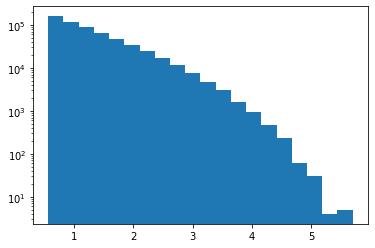

In [655]:
plt.hist(lnlam_mean, bins = 20)
plt.yscale('log')

(array([12706., 12061., 11806., 13292., 10792., 10370., 11962.,  9389.,
        11090., 10706.]),
 array([0.5625057 , 0.58004934, 0.59759295, 0.6151365 , 0.6326801 ,
        0.65022373, 0.66776735, 0.68531096, 0.7028545 , 0.7203981 ,
        0.73794174], dtype=float32),
 <BarContainer object of 10 artists>)

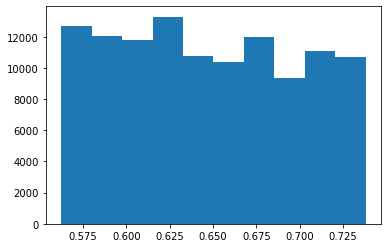

In [656]:
plt.hist(lnlam_mean[(lnlam_mean>=0.56) & (lnlam_mean<= 0.74)])

In [657]:
color_list = ['r','g','b','y','c','m','k','tab:cyan', "gold"]

In [658]:
np.sum(lnM>33)/len(lnM)

0.00967382504616975

In [659]:
mco = MonteCarloObservables(0.5,lnM, scatter_lam=scatter_lam, scatter_Mwl=scatter_Mwl, scatter_SZ=scatter_SZ)
NBINS = 8
lam_array, SZ_array, diff_array, count_array = mco.MC_calculate_mean_Mwl_given_lam_SZ(nbins = NBINS+1,correction=True)
lam_array_nc, SZ_array_nc, diff_array_nc, count_array_nc = mco.MC_calculate_mean_Mwl_given_lam_SZ(nbins = NBINS+1,correction=False)

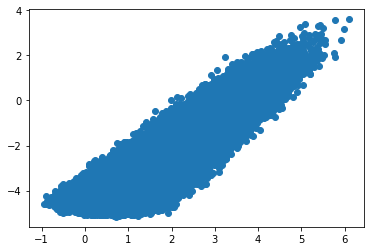

In [660]:
plt.scatter(mco.lnlam, mco.lnSZ)

In [664]:
count_array

array([[3.250e+02, 2.470e+02, 3.840e+02, 1.350e+02, 3.670e+02, 1.350e+02,
        1.500e+01, 5.000e+00],
       [2.830e+02, 2.770e+02, 4.220e+02, 1.550e+02, 4.760e+02, 2.740e+02,
        2.300e+01, 8.000e+00],
       [2.400e+02, 1.960e+02, 3.650e+02, 1.720e+02, 5.080e+02, 3.610e+02,
        4.700e+01, 1.900e+01],
       [4.590e+02, 4.220e+02, 8.220e+02, 3.780e+02, 1.574e+03, 1.643e+03,
        3.700e+02, 2.030e+02],
       [7.200e+01, 9.800e+01, 1.870e+02, 1.250e+02, 6.490e+02, 1.369e+03,
        5.460e+02, 4.650e+02],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.300e+01,
        1.300e+01, 2.100e+01],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00]])

In [665]:
diff_array - diff_array_nc

array([[ 0.31154238,  0.34270316,  0.38545052,  0.42734972,  0.49601898,
         0.64189051,         nan,         nan],
       [ 0.16972777,  0.2008813 ,  0.24361871,  0.28550816,  0.35416143,
         0.49999901,         nan,         nan],
       [ 0.06387289,  0.09502735,  0.13776605,  0.17965675,  0.24831208,
         0.39415403,  0.53409173,         nan],
       [-0.09467563, -0.06351709, -0.0207728 ,  0.02112339,  0.08978772,
         0.23564876,  0.3756048 ,  0.44965203],
       [-0.422046  , -0.3909025 , -0.34817883, -0.30630287, -0.23767167,
        -0.09187057,  0.04810828,  0.12216759],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan]])

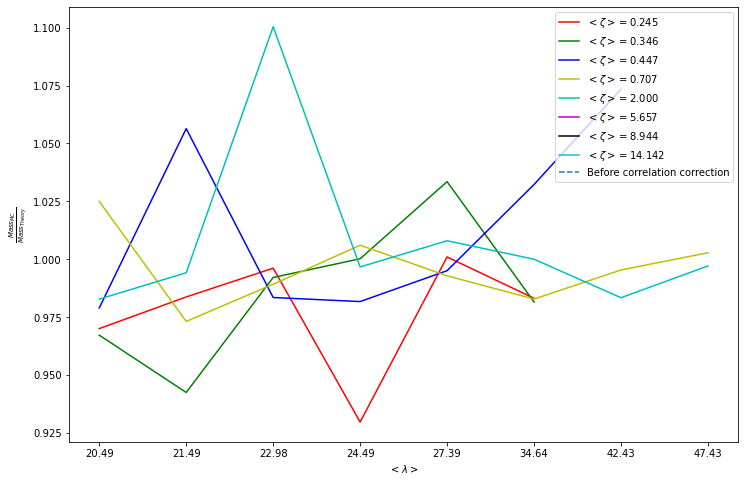

In [666]:
plt.figure(figsize=[12,8])
for i in range(NBINS):
    plt.plot(range(NBINS), np.exp(diff_array[i,:]), color=f'{color_list[i]}',label= f"$<\zeta> = {np.exp(SZ_array[i]):.3f}$")
    # plt.plot(range(NBINS), np.exp(diff_array_nc[i,:]), "--", color=f'{color_list[i]}')
plt.plot([], [], '--', label="Before correlation correction")    
plt.legend()
# locs, labels = plt.xticks() 
plt.xticks(np.arange(0, NBINS, step=1), [f"{np.exp(lam):.2f}" for lam in lam_array])
plt.xlabel("$<\lambda>$")
plt.ylabel(r"$\frac{Mass_{MC}}{Mass_{Theory}}$")
# plt.title("Comparision Before&After r Correction")
plt.show()

In [502]:
r_array = [0,0.25,0.5,0.75,0.99]

diff_list = [None] * len(r_array)
lam_list = [None] * len(r_array)
SZ_list = [None] * len(r_array)
count_list = [None] * len(r_array)

diff_list_nc = [None] * len(r_array)
lam_list_nc = [None] * len(r_array)
SZ_list_nc = [None] * len(r_array)
count_list_nc = [None] * len(r_array)

for i in range(len(r_array)):
    mco = MonteCarloObservables(r_array[i], lnM, scatter_lam=scatter_lam, scatter_Mwl=scatter_Mwl, scatter_SZ = scatter_SZ)
    lam_list[i], SZ_list[i], diff_list[i], count_list[i] = mco.MC_calculate_mean_Mwl_given_lam_SZ(nbins = NBINS+1,correction=True)
    lam_list_nc[i], SZ_list_nc[i], diff_list_nc[i], count_list_nc[i] = mco.MC_calculate_mean_Mwl_given_lam_SZ(nbins = NBINS+1,correction=False)

In [503]:
np.sum(np.array(diff_list), axis=0)

array([[ 9.57074351e-02, -1.04545729e-01, -9.60194876e-02,
        -8.99799311e-02, -8.33143404e-02, -6.17244126e-02,
        -2.63878988e-02, -2.98042888e-02,  4.78721403e-01],
       [ 1.51051835e-01,  1.22363469e-03, -1.57991330e-02,
        -1.48419510e-02,  1.10500011e-02, -2.60188543e-02,
         1.80480824e-03,  5.11186523e-02,  4.21542783e-01],
       [ 1.32021295e-01,  1.02174304e-02,  5.17621548e-03,
        -7.26829786e-03,  2.21693676e-02,  2.75993218e-02,
         3.83050922e-02,  8.99634539e-02,  2.10075249e-01],
       [ 4.90400880e-02,  1.44805311e-02, -9.85145429e-04,
        -4.63158679e-03,  4.88953107e-03,  1.47363754e-02,
         2.83485660e-02,  7.97169831e-02,  2.66932814e-01],
       [ 7.23796806e-03, -8.33926198e-03,  1.31867816e-02,
        -2.43658116e-03, -4.93020905e-03, -9.32572233e-04,
         1.25655246e-02,  2.20819081e-02,  2.69389433e-01],
       [-4.20476048e-02, -2.87047377e-02,  3.68578188e-03,
        -1.12326718e-02, -7.54985599e-04, -1.987205

In [504]:
np.sum(np.array(diff_list),axis=1)

array([[ 0.37594143,  0.16128509,  0.08761326,  0.04749639,  0.01898325,
        -0.03163951, -0.01551661, -0.10639307, -0.01051765],
       [-0.13480876, -0.06224951,  0.04624593,  0.03620205, -0.00496816,
         0.00149952, -0.08521451, -0.08568771,  0.10483499],
       [-0.65458071,  0.16060949,  0.02107865,  0.04651022,  0.00314369,
        -0.00834857,  0.04472471,  0.0405098 ,  0.4015278 ],
       [-0.20108637, -0.04949406, -0.06341678, -0.0781641 , -0.01504747,
        -0.03153657,  0.01855016,  0.06914568,  0.57806759],
       [-0.11611329, -0.13459041, -0.05290436, -0.038827  , -0.03507883,
        -0.01263012,  0.05062208,  0.19836914,  0.76958154]])

In [505]:
np.sum(np.array(diff_list), axis=2)

array([[-4.30656049e-01, -9.79064971e-02, -1.65658204e-02,
        -5.48645170e-02, -1.78285018e-02, -1.53689722e-02,
         1.04467225e-01,  5.58075778e-02,  1.00016811e+00],
       [-3.01832911e-01,  6.09686469e-03, -8.80857499e-03,
         3.81334587e-02,  3.44543530e-02,  1.14488195e-02,
        -5.69636297e-02,  8.53900657e-02,  7.93540387e-03],
       [ 7.35623207e-03,  1.85468079e-01,  1.23069494e-01,
         1.00247211e-01,  7.41113888e-02,  3.75872616e-02,
        -7.26312890e-04,  1.52565161e-02, -4.87194793e-01],
       [ 2.96586001e-01,  1.56513616e-01,  1.78808278e-01,
         1.58199060e-01,  9.60997275e-02,  3.36417073e-02,
        -7.47445691e-02, -1.41788214e-01, -4.76297522e-01],
       [ 5.11199476e-01,  3.30959713e-01,  2.51755751e-01,
         2.10812944e-01,  1.20986023e-01,  4.21346679e-02,
        -4.55454814e-02, -1.98705392e-01, -5.95168937e-01]])

In [506]:
np.array(lam_list)

array([[-0.33112474,  0.57785385,  0.77071251,  0.93453869,  1.09492025,
         1.26675291,  1.46574357,  1.71828001,  2.08971501],
       [-0.24798528,  0.57718918,  0.7698151 ,  0.93323173,  1.0937567 ,
         1.26523658,  1.46451597,  1.71801366,  2.09048289],
       [-0.24152413,  0.57738328,  0.7703507 ,  0.93414952,  1.09391117,
         1.26510013,  1.46285676,  1.71526573,  2.0897207 ],
       [-0.24442916,  0.57702345,  0.76974154,  0.93359986,  1.09379369,
         1.26508358,  1.46340645,  1.71703675,  2.09092436],
       [-0.3960202 ,  0.57597462,  0.77030111,  0.93439647,  1.0939308 ,
         1.26564469,  1.46441896,  1.71633834,  2.090272  ]])

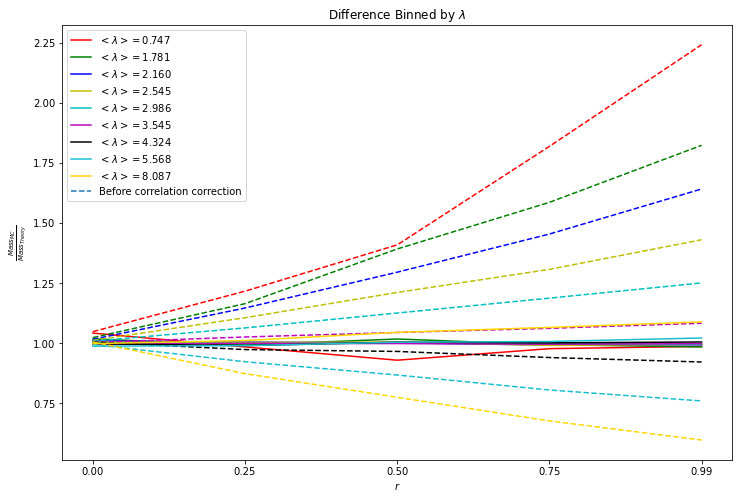

In [507]:
#binned by lambda, marginalize SZ
diff_array_lambda = np.sum(np.array(diff_list), axis=1)/np.sum(np.invert(np.array(diff_list)==0),axis=1)
diff_array_lambda_nc = np.sum(np.array(diff_list_nc), axis=1)/np.sum(np.invert(np.array(diff_list_nc)==0),axis=1)

plt.figure(figsize=[12,8])
for i in range(len(lam_list[0])):
    plt.plot(range(len(r_array)), np.exp(diff_array_lambda[:,i]), color=f"{color_list[i]}", label= f"$<\lambda> = {np.exp(np.mean(np.array(lam_list)[:,i])):.3f}$")
    plt.plot(range(len(r_array)), np.exp(diff_array_lambda_nc[:,i]), "--", color=f"{color_list[i]}")
plt.plot([], [], '--', label="Before correlation correction")    
plt.legend()
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 5, step=1), [f"{r:.2f}" for r in r_array])
plt.xlabel("$r$")
plt.ylabel(r"$\frac{Mass_{MC}}{Mass_{Theory}}$")
plt.title("Difference Binned by $\lambda$")
plt.show()

In [508]:
np.exp(1.5)

4.4816890703380645

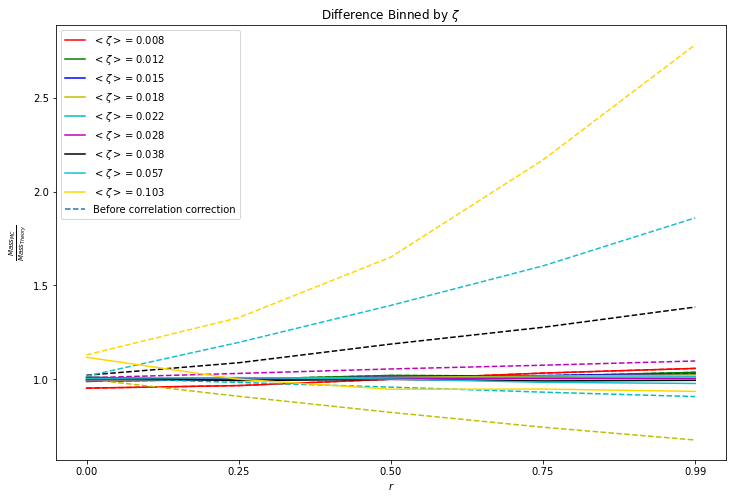

In [509]:
#binned by SZ, marginalize lambda
diff_array_SZ = np.sum(np.array(diff_list), axis=2)/np.sum(np.invert(np.array(diff_list)==0),axis=2)
diff_array_SZ_nc = np.sum(np.array(diff_list_nc), axis=2)/np.sum(np.invert(np.array(diff_list_nc)==0),axis=2)

plt.figure(figsize=[12,8])
for i in range(len(SZ_list[0])):
    plt.plot(range(len(r_array)), np.exp(diff_array_SZ[:,i]),color=f"{color_list[i]}", label= f"$<\zeta> = {np.exp(np.mean(np.array(SZ_list)[:,i])):.3f}$")
    plt.plot(range(len(r_array)), np.exp(diff_array_SZ_nc[:,i]),"--",color=f"{color_list[i]}")
plt.plot([], [], '--', label="Before correlation correction")
plt.legend()
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 5, step=1), [f"{r:.2f}" for r in r_array])
plt.xlabel("$r$")
plt.ylabel(r"$\frac{Mass_{MC}}{Mass_{Theory}}$")
plt.title("Difference Binned by $\zeta$")
plt.show()

In [421]:
beta = 2
r = 0.5
num = r * scatter_Mwl * (scatter_lam/alpha_lam)*(0.5+(scatter_SZ/alpha_SZ)**2*beta)
den = (scatter_SZ/alpha_SZ)**2 + (scatter_lam/alpha_lam)**2
print(num/den)

0.317473089601856


In [422]:
def diff_mu(lam,SZ):
    return((lam-pi_lam)/alpha_lam - (SZ-pi_SZ)/alpha_SZ)

In [295]:
for i in range(nh):
    diff_mu(lnlam_mean[i],lnSZ_mean[i])

In [296]:
diff_mu(lnlam_mean[1000],lnSZ_mean[1000])

-9.558279678856252e-07

In [297]:
lnlam_mean = alpha_lam*lnM + pi_lam
lnSZ_mean = alpha_SZ*lnM + pi_SZ

In [298]:
lnlam_mean[10]

2.3268223

In [299]:
scatter_SZ**2

0.023104

In [300]:
mco = MonteCarloObservables(0.5,lnM, scatter_lam=scatter_lam, scatter_Mwl=scatter_Mwl, scatter_SZ=scatter_SZ)

(array([1.51000e+02, 2.93700e+03, 2.63870e+04, 1.09013e+05, 2.01349e+05,
        1.68531e+05, 6.40000e+04, 1.10640e+04, 8.00000e+02, 2.50000e+01]),
 array([-1.74669507, -1.38125399, -1.01581291, -0.65037182, -0.28493074,
         0.08051034,  0.44595142,  0.81139251,  1.17683359,  1.54227467,
         1.90771576]),
 <BarContainer object of 10 artists>)

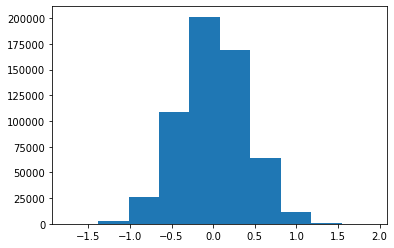

In [251]:
plt.hist(diff_mu(mco.lnlam,mco.lnSZ))